In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

$$\text{Plot Confusion Matrix}$$

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

$$\text{ColumnSelector, NumberSelector, OHEEncoder}$$

In [3]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

$$\text{Business Threshold Calibrate}$$

In [4]:
def business_threshold_calibrate(y_test, y_test_pred, rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0

    rubl_ML_ = float('inf')

    rs = []
    n = 100
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_test_pred > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    print('расходы, если использовать МЛ:', rubl_ML_)  

    plt.figure(figsize = (10, 7))
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

In [5]:
df = pd.read_csv('train_case2.csv', ';')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

In [7]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [8]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

### Task №1-5

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [10]:
models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

In [11]:
t_list, f_list, p_list, r_list, roc_list, rubl_list, full_test = [], [], [], [], [], [], []
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

for model in models:
    classifier = Pipeline([('features', feats), ('classifier', eval(model+'(random_state = 42)'))])    
    classifier.fit(X_train, y_train)
    
    y_test_pred = classifier.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
    precision, recall = precision[:-1], recall[:-1]

    nzm_prec = precision != 0
    nzm_rec = recall != 0
    nzm = nzm_prec * nzm_rec

    precision, recall, thresholds = precision[nzm], recall[nzm], thresholds[nzm]

    fscore = (2 * precision * recall) / (precision + recall)

    ix = np.argmax(fscore)
    t_list.append(thresholds[ix])
    f_list.append(fscore[ix]) 
    p_list.append(precision[ix])
    r_list.append(recall[ix])
    roc_list.append(roc_auc_score(y_test, y_test_pred))
    
    
    cnf_matrix = confusion_matrix(y_test, y_test_pred > thresholds[ix])
    
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
    rubl_list.append(rubl_ML)
    full_test.append(rubl_test_all)


results = pd.DataFrame({'Threshold': t_list,
                        'F-score': f_list,
                        'Precision': p_list,
                        'Recall': r_list,
                        'ROC-AUC': roc_list,
                        'Full cost': full_test,
                        'ML cost': rubl_list}, index = models, columns = ['Threshold', 'F-score', 'Precision', 'Recall', 'ROC-AUC', 'Full cost', 'ML cost'])

results['Relative difference'] = (results['Full cost'] - results['ML cost'])/results['Full cost']
results



,Threshold,F-score,Precision,Recall,ROC-AUC,Full cost,ML cost,Relative difference
LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,154700000,152974200,0.011156
DecisionTreeClassifier,0.000000,0.663102,0.496000,1.000000,0.635325,154700000,158370000,-0.023723
RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,154700000,153699400,0.006468
GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,154700000,153122800,0.010195


* Модель <b>LogisticRegression</b> справилась с задачей лучше остальных (при дефолтных параметрах модели).

In [12]:
classifier = Pipeline([('features', feats), ('classifier', LogisticRegression(random_state = 42))])    
classifier.fit(X_train, y_train)

y_test_pred = classifier.predict_proba(X_test)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)
precision, recall = precision[:-1], recall[:-1]

nzm_prec = precision != 0
nzm_rec = recall != 0
nzm = nzm_prec * nzm_rec

precision, recall, thresholds = precision[nzm], recall[nzm], thresholds[nzm]

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

cnf_matrix = confusion_matrix(y_test, y_test_pred > thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
print(f'Full test: {rubl_test_all}')
print(f'ML test: {rubl_ML}')

Full test: 154700000
ML test: 152974200


расходы, если использовать МЛ: 152642200


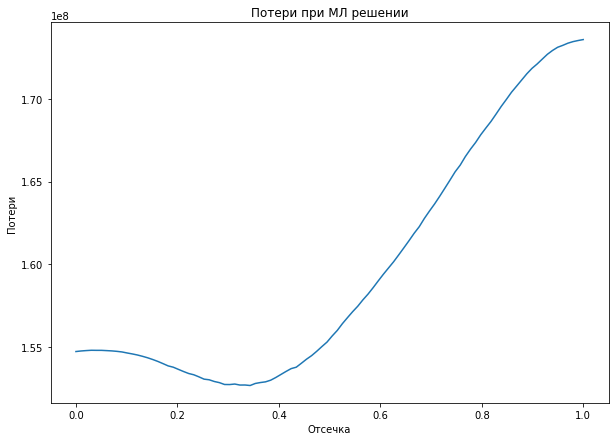

уровень порога по бизнес метрике 0.343
уровень порога по f1 метрике 0.387


In [13]:
busines_tr = business_threshold_calibrate(y_test, y_test_pred,
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print(f'уровень порога по бизнес метрике {busines_tr:.3f}')
print(f'уровень порога по f1 метрике {thresholds[ix]:.3f}')